# MRS cross-dichroic response derivation
We import the response values and errors derived in Notebook 3 from the MIRI internal calibration source observations. These are then used to derive the MRS spectrophotometric response to an external extended source observation in cross-dichroic configuration.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
import mrsobs

import numpy as np
from astropy.io import fits
from scipy.interpolate import interp1d
from astropy.convolution import convolve, Box2DKernel
import matplotlib.pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# MRS spectral bands (including cross-dichroic configurations)
bands = ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C", 
         "2AxB","2AxC","2BxA","2BxC","2CxA","2CxB",
         "3AxB","3AxC","3BxA","3BxC","3CxA","3CxB",
         "4AxB","4AxC","4BxA","4BxC","4CxA","4CxB"]

cross_bands = ["2AxB","2AxC","2BxA","2BxC","2CxA","2CxB",
               "3AxB","3AxC","3BxA","3BxC","3CxA","3CxB",
               "4AxB","4AxC","4BxA","4BxC","4CxA","4CxB"]

# load spectrophotometric responses derived Notebook 3
R_pixMap  = funcs.load_obj('NominalAndCrossDichroicIntCalSourceResponse')
dR_pixMap = funcs.load_obj('NominalAndCrossDichroicIntCalSourceResponseError')

In [3]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
dichroicDir   = workDir+'MRSWaveCal/MrsFilterTransmissions/'
lvl2path  = workDir+'FM_data/LVL2/'

# Populate dictionaries with the wavelength, pixel size, validity maps, and latest spectrophotometric CDP data
# (corresponding to the detector plane)

sliceMap   = {}
sizeMap    = {}
validMap   = {}
lambdaMap  = {}
photom     = {}
photom_err = {}

for band in bands:
    if len(band) == 4:
        # cross-dichroic configuration
        continue
    # print "Band {}".format(band)
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    sliceMap[band]  = d2cMaps['sliceMap']
    lambdaMap[band] = d2cMaps['lambdaMap']
    sizeMap[band]   = funcs.get_pixel_spatial_area(band=band,d2cMaps=d2cMaps)
    
    # create a "valid" map with all the pixels inside the slices of a particular band
    channel = int(band[0])
    # slice numbers in the slice map of the distortion CDP for this band
    sliceInventory = np.unique(sliceMap[band])
    slicesInBand = sliceInventory[np.where( (sliceInventory >= 100*channel ) & (sliceInventory <100*(channel+1)))]
    
    validMap[band] = np.zeros(sliceMap[band].shape)
    for ss in slicesInBand:
        s = int(ss - 100*channel)
        # construct a list of y,x coordinates of detector pixels belonging to slices of this band
        pixels = np.where(sliceMap[band] == ss)
        validMap[band][pixels] = 1
    
    # latest spectrophotometric calibration data product
    photom[band] = funcs.get_cdps(band,cdpDir)[1]
    photom_err[band] = fits.open(funcs.get_cdps(band,cdpDir,output='filepath')[1])[2].data

In [4]:
# Path to dichroic transmission data
MrsFilterTransmDir   = workDir+"MRSWaveCal/MrsFilterTransmissions/"
# Read the measured transmission curves from the csv files
# zeroth colum is wavelength [micrometer]
# first column is room temperature transmission
# second column is 7K transmission
col = 2
filterWave= np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_1a.csv", delimiter=";")[:,0]
D1A = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_1a.csv", delimiter=";")[:,col]/100.
D1B = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_1b.csv", delimiter=";")[:,col]/100.
D1C = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_1c.csv", delimiter=";")[:,col]/100.
D2A = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_2a.csv", delimiter=";")[:,col]/100.
D2B = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_2b.csv", delimiter=";")[:,col]/100.
D2C = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_2c.csv", delimiter=";")[:,col]/100.
D3A = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_3a.csv", delimiter=";")[:,col]/100.
D3B = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_3b.csv", delimiter=";")[:,col]/100.
D3C = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_3c.csv", delimiter=";")[:,col]/100.

Let's plot the response values derived from the internal calibration source in Notebook 3, and compare the ratio of the responses to the transmission of the dichroics.

<IPython.core.display.Javascript object>


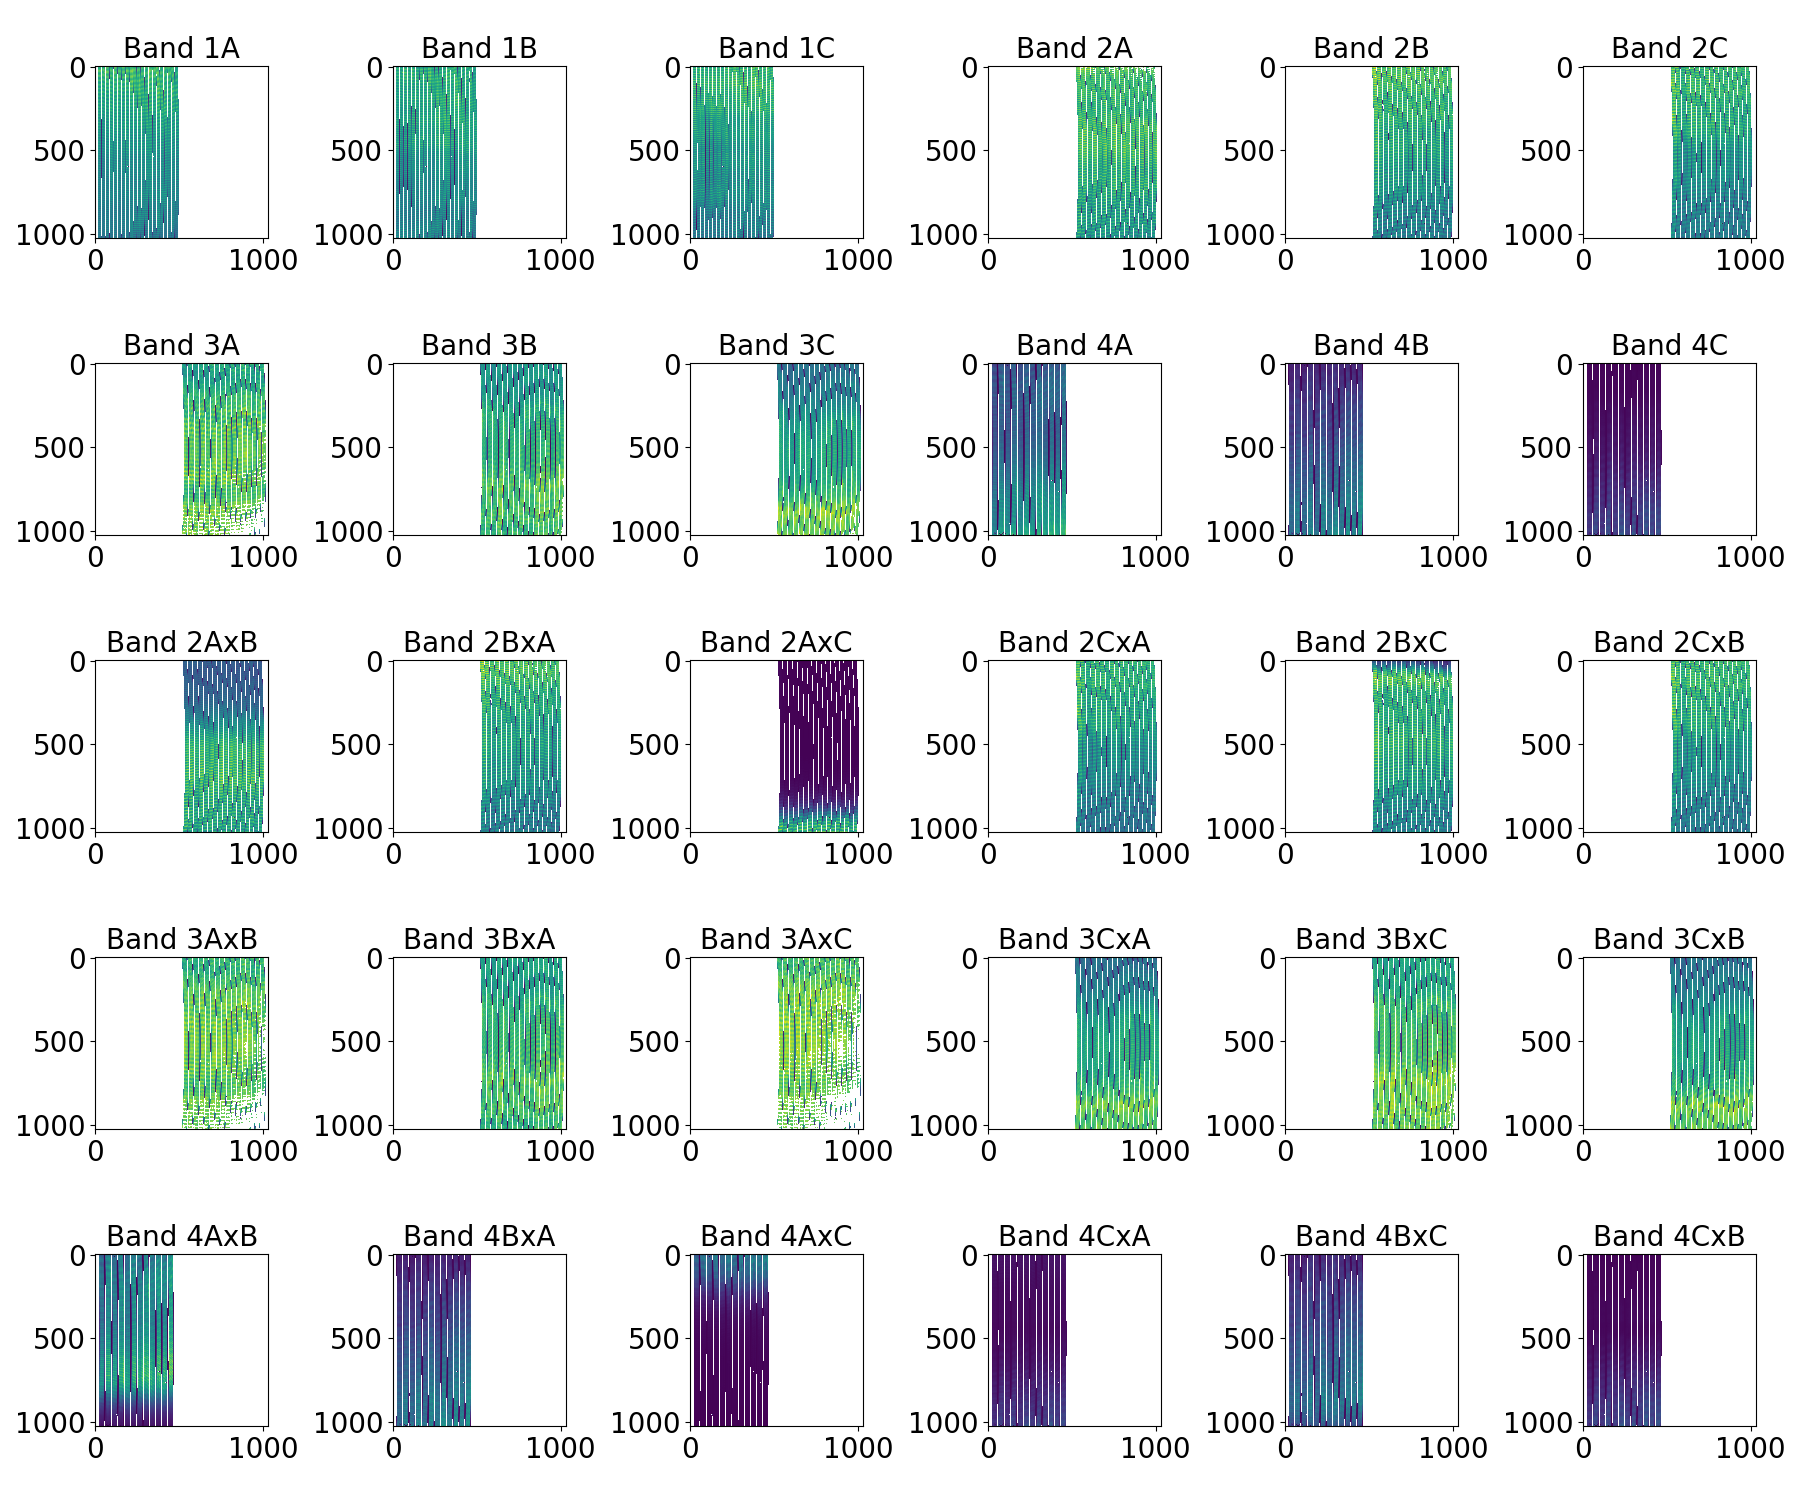

In [5]:
fig,axs = plt.subplots(5,6,figsize=(18,15))
axs[0,0].imshow(R_pixMap['1A'])
axs[0,0].set_title('Band 1A')
axs[0,1].imshow(R_pixMap['1B'])
axs[0,1].set_title('Band 1B')
axs[0,2].imshow(R_pixMap['1C'])
axs[0,2].set_title('Band 1C')
axs[0,3].imshow(R_pixMap['2A'])
axs[0,3].set_title('Band 2A')
axs[0,4].imshow(R_pixMap['2B'])
axs[0,4].set_title('Band 2B')
axs[0,5].imshow(R_pixMap['2C'])
axs[0,5].set_title('Band 2C')
axs[1,0].imshow(R_pixMap['3A'])
axs[1,0].set_title('Band 3A')
axs[1,1].imshow(R_pixMap['3B'])
axs[1,1].set_title('Band 3B')
axs[1,2].imshow(R_pixMap['3C'])
axs[1,2].set_title('Band 3C')
axs[1,3].imshow(R_pixMap['4A'])
axs[1,3].set_title('Band 4A')
axs[1,4].imshow(R_pixMap['4B'])
axs[1,4].set_title('Band 4B')
axs[1,5].imshow(R_pixMap['4C'])
axs[1,5].set_title('Band 4C')
axs[2,0].imshow(R_pixMap['2AxB'])
axs[2,0].set_title('Band 2AxB')
axs[2,1].imshow(R_pixMap['2BxA'])
axs[2,1].set_title('Band 2BxA')
axs[2,2].imshow(R_pixMap['2AxC'])
axs[2,2].set_title('Band 2AxC')
axs[2,3].imshow(R_pixMap['2CxA'])
axs[2,3].set_title('Band 2CxA')
axs[2,4].imshow(R_pixMap['2BxC'])
axs[2,4].set_title('Band 2BxC')
axs[2,5].imshow(R_pixMap['2CxB'])
axs[2,5].set_title('Band 2CxB')
axs[3,0].imshow(R_pixMap['3AxB'])
axs[3,0].set_title('Band 3AxB')
axs[3,1].imshow(R_pixMap['3BxA'])
axs[3,1].set_title('Band 3BxA')
axs[3,2].imshow(R_pixMap['3AxC'])
axs[3,2].set_title('Band 3AxC')
axs[3,3].imshow(R_pixMap['3CxA'])
axs[3,3].set_title('Band 3CxA')
axs[3,4].imshow(R_pixMap['3BxC'])
axs[3,4].set_title('Band 3BxC')
axs[3,5].imshow(R_pixMap['3CxB'])
axs[3,5].set_title('Band 3CxB')
axs[4,0].imshow(R_pixMap['4AxB'])
axs[4,0].set_title('Band 4AxB')
axs[4,1].imshow(R_pixMap['4BxA'])
axs[4,1].set_title('Band 4BxA')
axs[4,2].imshow(R_pixMap['4AxC'])
axs[4,2].set_title('Band 4AxC')
axs[4,3].imshow(R_pixMap['4CxA'])
axs[4,3].set_title('Band 4CxA')
axs[4,4].imshow(R_pixMap['4BxC'])
axs[4,4].set_title('Band 4BxC')
axs[4,5].imshow(R_pixMap['4CxB'])
axs[4,5].set_title('Band 4CxB')
plt.tight_layout()

By taking the ratio of different responses, the dichroic transmission can be extracted. This transmission is compared to the lab data of the MRS dichroics.

### Channel 1-3

<IPython.core.display.Javascript object>


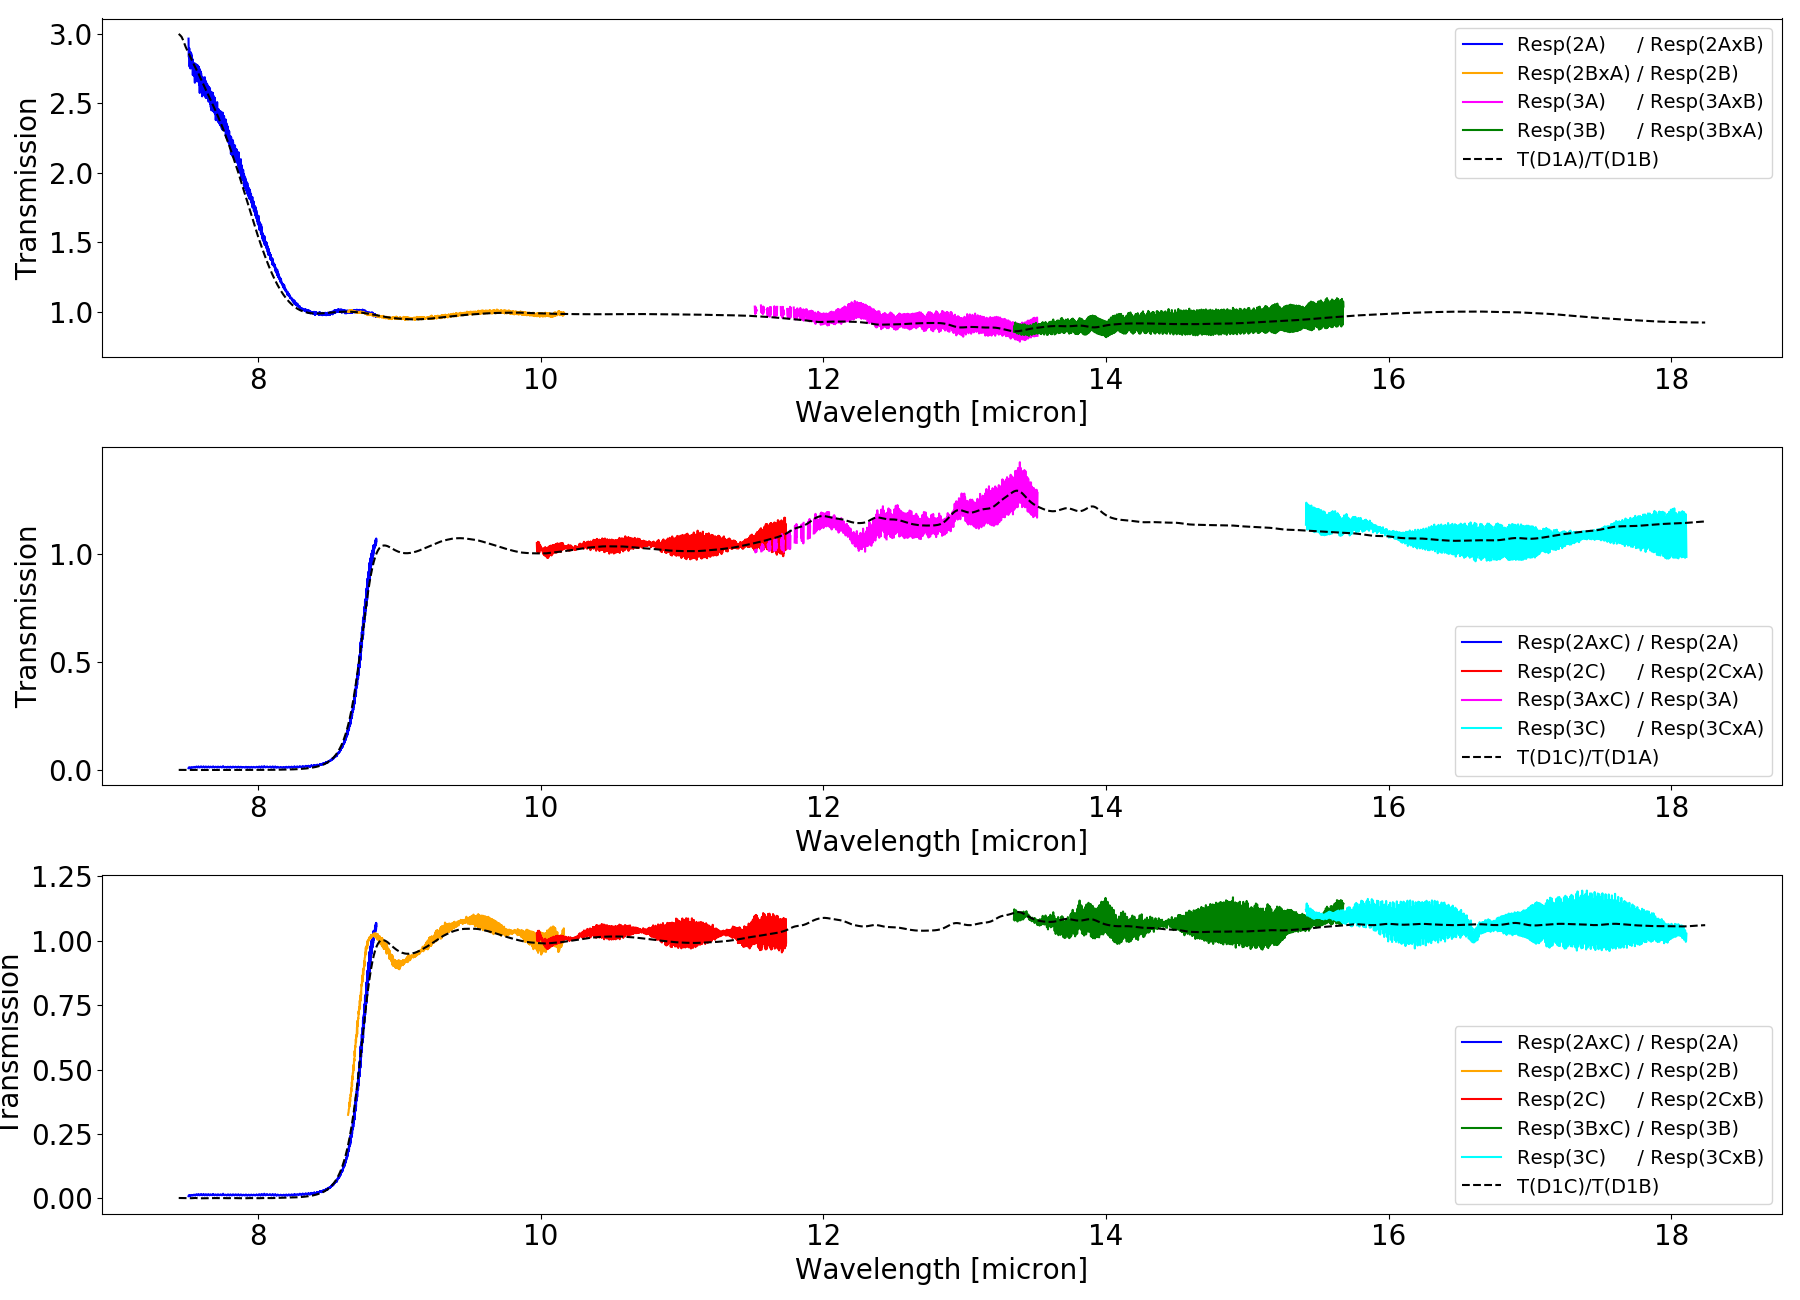

In [67]:
import mrs_aux as maux
sel = (filterWave>=maux.MRS_bands['2A'][0]) & (filterWave<=maux.MRS_bands['3C'][1])
fig,axs = plt.subplots(3,1,figsize=(18,13))
axs[0].plot(lambdaMap['2A'][:,537],(R_pixMap["2A"]/R_pixMap["2AxB"])[:,537],'b',label='Resp(2A)     / Resp(2AxB)')
axs[0].plot(lambdaMap['2B'][:,537],(R_pixMap["2BxA"]/R_pixMap["2B"])[:,537],'orange',label='Resp(2BxA) / Resp(2B)')
axs[0].plot(lambdaMap['3A'][:,537],(R_pixMap["3A"]/R_pixMap["3AxB"])[:,537],'magenta',label='Resp(3A)     / Resp(3AxB)')
axs[0].plot(lambdaMap['3B'][:,537],(R_pixMap["3BxA"]/R_pixMap["3B"])[:,537],'g',label='Resp(3B)     / Resp(3BxA)')
axs[0].plot(filterWave[sel],(D1A/D1B)[sel],'k',linestyle='dashed',label='T(D1A)/T(D1B)')

axs[1].plot(lambdaMap['2A'][:,537],(R_pixMap["2AxC"]/R_pixMap["2A"])[:,537],'b',label='Resp(2AxC) / Resp(2A)')
axs[1].plot(lambdaMap['2C'][:,537],(R_pixMap["2C"]/R_pixMap["2CxA"])[:,537],'r',label='Resp(2C)     / Resp(2CxA)')
axs[1].plot(lambdaMap['3A'][:,537],(R_pixMap["3AxC"]/R_pixMap["3A"])[:,537],'magenta',label='Resp(3AxC) / Resp(3A)')
axs[1].plot(lambdaMap['3C'][:,537],(R_pixMap["3C"]/R_pixMap["3CxA"])[:,537],'cyan',label='Resp(3C)     / Resp(3CxA)')
axs[1].plot(filterWave[sel],(D1C/D1A)[sel],'k',linestyle='dashed',label='T(D1C)/T(D1A)')

axs[2].plot(lambdaMap['2A'][:,537],(R_pixMap["2AxC"]/R_pixMap["2A"])[:,537],'b',label='Resp(2AxC) / Resp(2A)')
axs[2].plot(lambdaMap['2B'][:,537],(R_pixMap["2BxC"]/R_pixMap["2B"])[:,537],'orange',label='Resp(2BxC) / Resp(2B)')
axs[2].plot(lambdaMap['2C'][:,537],(R_pixMap["2C"]/R_pixMap["2CxB"])[:,537],'r',label='Resp(2C)     / Resp(2CxB)')
axs[2].plot(lambdaMap['3B'][:,537],(R_pixMap["3BxC"]/R_pixMap["3B"])[:,537],'g',label='Resp(3BxC) / Resp(3B)')
axs[2].plot(lambdaMap['3C'][:,537],(R_pixMap["3C"]/R_pixMap["3CxB"])[:,537],'cyan',label='Resp(3C)     / Resp(3CxB)')
axs[2].plot(filterWave[sel],(D1C/D1B)[sel],'k',linestyle='dashed',label='T(D1C)/T(D1B)')

for plot in range(3):
    axs[plot].legend()
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Transmission')
plt.tight_layout()

The ratio of the different responses are used to relate the internal calibration source observation response to the external source observation response. In fact these are found to be in exceedingly good agreement with the lab data of the dichroic transmissions. As such there are two options to derive the cross-dichroic configuration response to an external source. One can either use the ratio of the int.cal.source-derived responses, or the lab data of the dichroic transmission. The latter option is useful in the case that the former option introduced too much noise.

In [5]:
def stdev_propag(A,B,sigmaA,sigmaB):
    # assume uncorrelated noise, for either case of f = A*B or f = A/B
    # ==> sigma_f = |f|*sqrt((sigmaA/A)**2 +(sigmaB/B)**2)
    return np.abs(A/B)*np.sqrt( (sigmaA/A)**2 + (sigmaB/B)**2 )

In [6]:
# Response cross-dichroic band 2AxB
band = '2AxB'

# Create dictionary with all transmission ratios and all derived responses
transm_pixMap = {}
response      = {}
response_err  = {}

# interpolate the corresponding lab data transmission ratio applicable to specified band
sel = (D1A!=0) & (D1B!=0)
ip_transm = interp1d(filterWave[sel], (D1A/D1B)[sel], kind='cubic')

# create pixel map of lab data transmission ratio
transm_pixMap[band] = np.full( validMap[band[:2]].shape, np.nan )

sel = (validMap[band[:2]]==1)
waves = np.reshape(lambdaMap[band[:2]][sel], -1)
transm_pixMap[band][sel] = ip_transm(waves)

# Derive MRS response based on the internal calibration source measurements and the lab data of the dichroic transmissions.
# For this cross-dichroic band, the int.cal.source response ratio is used to derive the MRS response of said band.
# To fill in the abundant NaNs in the int.cal.source response ratio pixel map, we use the response derived from using the lab data (other ideas are welcome).
response[band+'_lab']  = photom[band[:2]]/ transm_pixMap[band]
response[band+'_data'] = photom[band[:2]]/(R_pixMap[band[:2]]/R_pixMap[band])
response[band+'_data'][np.isnan(response[band+'_data'])] = response[band+'_lab'][np.isnan(response[band+'_data'])]

# error propagation
response_err[band+'_lab']  = photom_err[band[:2]]/ transm_pixMap[band]
R_pixMap_ratio_err         = stdev_propag(R_pixMap[band[:2]],R_pixMap[band],dR_pixMap[band[:2]],dR_pixMap[band])
response_err[band+'_data'] = stdev_propag(photom[band[:2]],(R_pixMap[band[:2]]/R_pixMap[band]),photom_err[band[:2]],R_pixMap_ratio_err)
response_err[band+'_data'][np.isnan(response[band+'_data'])] = response_err[band+'_lab'][np.isnan(response[band+'_data'])]

# save final output
response[band]     = response[band+'_data'].copy()
response_err[band] = response_err[band+'_data'].copy()

In [7]:
# Response cross-dichroic band 2BxA
band = '2BxA'

# create pixel map of lab data transmission ratio
transm_pixMap[band] = np.full( validMap[band[:2]].shape, np.nan )

sel = (validMap[band[:2]]==1)
waves = np.reshape(lambdaMap[band[:2]][sel], -1)
transm_pixMap[band][sel] = ip_transm(waves)

# Derive MRS response based on the internal calibration source measurements and the lab data of the dichroic transmissions.
# For this cross-dichroic band, the int.cal.source response ratio is used to derive the MRS response of said band.
# To fill in the abundant NaNs in the int.cal.source response ratio pixel map, we use the response derived from using the lab data (other ideas are welcome).
response[band+'_lab']  = transm_pixMap[band] * photom[band[:2]]
response[band+'_data'] = (R_pixMap[band]/R_pixMap[band[:2]]) * photom[band[:2]]
response[band+'_data'][np.isnan(response[band+'_data'])] = response[band+'_lab'][np.isnan(response[band+'_data'])]

# error propagation
response_err[band+'_lab']  = transm_pixMap[band] * photom_err[band[:2]]
R_pixMap_ratio_err         = stdev_propag(R_pixMap[band],R_pixMap[band[:2]],dR_pixMap[band],dR_pixMap[band[:2]])
response_err[band+'_data'] = stdev_propag((R_pixMap[band]/R_pixMap[band[:2]]),photom[band[:2]],R_pixMap_ratio_err,photom_err[band[:2]])
response_err[band+'_data'][np.isnan(response[band+'_data'])] = response_err[band+'_lab'][np.isnan(response[band+'_data'])]

# save final output
response[band]     = response[band+'_data'].copy()
response_err[band] = response_err[band+'_data'].copy()

In [8]:
# Response cross-dichroic band 3AxB
band = '3AxB'

# create pixel map of lab data transmission ratio
transm_pixMap[band] = np.full( validMap[band[:2]].shape, np.nan )

sel = (validMap[band[:2]]==1)
waves = np.reshape(lambdaMap[band[:2]][sel], -1)
transm_pixMap[band][sel] = ip_transm(waves)

# Derive MRS response based on the internal calibration source measurements and the lab data of the dichroic transmissions.
# For this cross-dichroic band, the dichroic transmission lab data ratio is used to derive the MRS response of said band.
# The reasons to use the lab data are: 
# (1) the int.cal.source response ratio and the dichroic lab data ratio are in general agreement,
# (2) to minimize the noise in the derived response,
# (3) to mitigate the large number of NaNs in the int.cal.source data,
# (4) very importantly, to avoid introducing the spectral leak feature (at 12.2um) into the derived response
response[band+'_lab'] = photom[band[:2]]/ transm_pixMap[band]

# error propagation
response_err[band+'_lab'] = photom_err[band[:2]] / transm_pixMap[band]

# save final output
response[band]     = response[band+'_lab'].copy()
response_err[band] = response_err[band+'_lab'].copy()

In [9]:
# Response cross-dichroic band 3AxB
band = '3BxA'

# create pixel map of lab data transmission ratio
transm_pixMap[band] = np.full( validMap[band[:2]].shape, np.nan )

sel = (validMap[band[:2]]==1)
waves = np.reshape(lambdaMap[band[:2]][sel], -1)
transm_pixMap[band][sel] = ip_transm(waves)

# Derive MRS response based on the internal calibration source measurements and the lab data of the dichroic transmissions.
# For this cross-dichroic band, the dichroic transmission lab data ratio is used to derive the MRS response of said band.
# The reasons to use the lab data are: 
# (1) the int.cal.source response ratio and the dichroic lab data ratio are in agreement,
# (2) to minimize the noise in the derived response, 
# (3) to mitigate the large number of NaNs in the int.cal.source data
response[band+'_lab'] = photom[band[:2]]/ transm_pixMap[band]

# error propagation
response_err[band+'_lab'] = photom_err[band[:2]] / transm_pixMap[band]

# save final output
response[band]     = response[band+'_lab'].copy()
response_err[band] = response_err[band+'_lab'].copy()

In [10]:
# Response cross-dichroic band 2BxA
band = '2AxC'

# interpolate the corresponding lab data transmission ratio applicable to specified band
sel = (D1C!=0) & (D1A!=0)
ip_transm = interp1d(filterWave[sel], (D1C/D1A)[sel], kind='cubic')

# create pixel map of lab data transmission ratio
transm_pixMap[band] = np.full( validMap[band[:2]].shape, np.nan )

sel = (validMap[band[:2]]==1)
waves = np.reshape(lambdaMap[band[:2]][sel], -1)
transm_pixMap[band][sel] = ip_transm(waves)

# Derive MRS response based on the internal calibration source measurements and the lab data of the dichroic transmissions.
# For this cross-dichroic band, the int.cal.source response ratio is used to derive the MRS response of said band.
# To fill in the abundant NaNs in the int.cal.source response ratio pixel map, we use the response derived from using the lab data (other ideas are welcome).
response[band+'_lab'] = transm_pixMap[band] * photom[band[:2]]
response[band+'_data'] = (R_pixMap[band]/R_pixMap[band[:2]]) * photom[band[:2]]
response[band+'_data'][np.isnan(response[band+'_data'])] = response[band+'_lab'][np.isnan(response[band+'_data'])]

# error propagation
response_err[band+'_lab']  = transm_pixMap[band] * photom_err[band[:2]]
R_pixMap_ratio_err         = stdev_propag(R_pixMap[band],R_pixMap[band[:2]],dR_pixMap[band],dR_pixMap[band[:2]])
response_err[band+'_data'] = stdev_propag((R_pixMap[band]/R_pixMap[band[:2]]),photom[band[:2]],R_pixMap_ratio_err,photom_err[band[:2]])
response_err[band+'_data'][np.isnan(response[band+'_data'])] = response_err[band+'_lab'][np.isnan(response[band+'_data'])]

# save final output
response[band]     = response[band+'_data'].copy()
response_err[band] = response_err[band+'_data'].copy()

In [11]:
# Response cross-dichroic band 3AxB
band = '2CxA'

# create pixel map of lab data transmission ratio
transm_pixMap[band] = np.full( validMap[band[:2]].shape, np.nan )

sel = (validMap[band[:2]]==1)
waves = np.reshape(lambdaMap[band[:2]][sel], -1)
transm_pixMap[band][sel] = ip_transm(waves)

# Derive MRS response based on the internal calibration source measurements and the lab data of the dichroic transmissions.
# For this cross-dichroic band, the dichroic transmission lab data ratio is used to derive the MRS response of said band.
# The reasons to use the lab data are: 
# (1) the int.cal.source response ratio and the dichroic lab data ratio are in agreement,
# (2) to minimize the noise in the derived response, 
# (3) to mitigate the large number of NaNs in the int.cal.source data
response[band+'_lab'] = photom[band[:2]]/ transm_pixMap[band]

# error propagation
response_err[band+'_lab'] = photom_err[band[:2]] / transm_pixMap[band]

# save final output
response[band]     = response[band+'_lab'].copy()
response_err[band] = response_err[band+'_lab'].copy()

In [12]:
# Response cross-dichroic band 3AxB
band = '3AxC'

# create pixel map of lab data transmission ratio
transm_pixMap[band] = np.full( validMap[band[:2]].shape, np.nan )

sel = (validMap[band[:2]]==1)
waves = np.reshape(lambdaMap[band[:2]][sel], -1)
transm_pixMap[band][sel] = ip_transm(waves)

# Derive MRS response based on the internal calibration source measurements and the lab data of the dichroic transmissions.
# For this cross-dichroic band, the dichroic transmission lab data ratio is used to derive the MRS response of said band.
# The reasons to use the lab data are: 
# (1) the int.cal.source response ratio and the dichroic lab data ratio are in general agreement,
# (2) to minimize the noise in the derived response,
# (3) to mitigate the large number of NaNs in the int.cal.source data,
# (4) very importantly, to avoid introducing the spectral leak feature (at 12.2um) into the derived response
response[band+'_lab'] = transm_pixMap[band] * photom[band[:2]]

# error propagation
response_err[band+'_lab'] = transm_pixMap[band] * photom_err[band[:2]]

# save final output
response[band]     = response[band+'_lab'].copy()
response_err[band] = response_err[band+'_lab'].copy()

In [13]:
# Response cross-dichroic band 3AxB
band = '3CxA'

# create pixel map of lab data transmission ratio
transm_pixMap[band] = np.full( validMap[band[:2]].shape, np.nan )

sel = (validMap[band[:2]]==1)
waves = np.reshape(lambdaMap[band[:2]][sel], -1)
transm_pixMap[band][sel] = ip_transm(waves)

# Derive MRS response based on the internal calibration source measurements and the lab data of the dichroic transmissions.
# For this cross-dichroic band, the dichroic transmission lab data ratio is used to derive the MRS response of said band.
# The reasons to use the lab data are:
# (1) the int.cal.source response ratio and the dichroic lab data ratio are in agreement,
# (2) to minimize the noise in the derived response, 
# (3) to mitigate the large number of NaNs in the int.cal.source data
response[band+'_lab'] = photom[band[:2]]/ transm_pixMap[band]

# error propagation
response_err[band+'_lab'] = photom_err[band[:2]] / transm_pixMap[band]

# save final output
response[band]     = response[band+'_lab'].copy()
response_err[band] = response_err[band+'_lab'].copy()

In [14]:
# Response cross-dichroic band 2BxA
band = '2BxC'

# interpolate the corresponding lab data transmission ratio applicable to specified band
sel = (D1C!=0) & (D1B!=0)
ip_transm = interp1d(filterWave[sel], (D1C/D1B)[sel], kind='cubic')

# create pixel map of lab data transmission ratio
transm_pixMap[band] = np.full( validMap[band[:2]].shape, np.nan )

sel = (validMap[band[:2]]==1)
waves = np.reshape(lambdaMap[band[:2]][sel], -1)
transm_pixMap[band][sel] = ip_transm(waves)

# Derive MRS response based on the internal calibration source measurements and the lab data of the dichroic transmissions.
# For this cross-dichroic band, the int.cal.source response ratio is used to derive the MRS response of said band.
# The NaNs are not filled in because of the difference in the int.cal.source response ratio curve and the dichroic lab data transmission ratio curve.
# The ratio of the int.cal.source responses is smoothed using a Box2DKernel of 2 pixels size to reduce the high frequency noise in the final output.
response[band+'_lab']  = transm_pixMap[band] * photom[band[:2]]
smooth_R_ratio         = convolve((R_pixMap[band]/R_pixMap[band[:2]]), Box2DKernel(2))
response[band+'_data'] = smooth_R_ratio * photom[band[:2]]

# error propagation
response_err[band+'_lab']  = transm_pixMap[band] * photom_err[band[:2]]
R_pixMap_ratio_err         = stdev_propag(R_pixMap[band],R_pixMap[band[:2]],dR_pixMap[band],dR_pixMap[band[:2]])
response_err[band+'_data'] = stdev_propag((R_pixMap[band]/R_pixMap[band[:2]]),photom[band[:2]],R_pixMap_ratio_err,photom_err[band[:2]])

# save final output
response[band]     = response[band+'_data'].copy()
response_err[band] = response_err[band+'_data'].copy()

In [15]:
# Response cross-dichroic band 3AxB
band = '2CxB'

# create pixel map of lab data transmission ratio
transm_pixMap[band] = np.full( validMap[band[:2]].shape, np.nan )

sel = (validMap[band[:2]]==1)
waves = np.reshape(lambdaMap[band[:2]][sel], -1)
transm_pixMap[band][sel] = ip_transm(waves)

# Derive MRS response based on the internal calibration source measurements and the lab data of the dichroic transmissions.
# For this cross-dichroic band, the dichroic transmission lab data ratiois used to derive the MRS response of said band.
# The reasons to use the lab data are:
# (1) the int.cal.source response ratio and the dichroic lab data ratio are in agreement,
# (2) to minimize the noise in the derived response, 
# (3) to mitigate the large number of NaNs in the int.cal.source data
response[band+'_lab'] = photom[band[:2]]/ transm_pixMap[band]

# error propagation
response_err[band+'_lab'] = photom_err[band[:2]] / transm_pixMap[band]

# save final output
response[band]     = response[band+'_lab'].copy()
response_err[band] = response_err[band+'_lab'].copy()

In [16]:
# Response cross-dichroic band 3AxB
band = '3BxC'

# create pixel map of lab data transmission ratio
transm_pixMap[band] = np.full( validMap[band[:2]].shape, np.nan )

sel = (validMap[band[:2]]==1)
waves = np.reshape(lambdaMap[band[:2]][sel], -1)
transm_pixMap[band][sel] = ip_transm(waves)

# Derive MRS response based on the internal calibration source measurements and the lab data of the dichroic transmissions.
# For this cross-dichroic band, the dichroic transmission lab data ratiois used to derive the MRS response of said band.
# The reasons to use the lab data are:
# (1) the int.cal.source response ratio and the dichroic lab data ratio are in agreement,
# (2) to minimize the noise in the derived response, 
# (3) to mitigate the large number of NaNs in the int.cal.source data
response[band+'_lab'] = transm_pixMap[band] * photom[band[:2]] 

# error propagation
response_err[band+'_lab'] = transm_pixMap[band] * photom_err[band[:2]]

# save final output
response[band]     = response[band+'_lab'].copy()
response_err[band] = response_err[band+'_lab'].copy()

In [17]:
# Response cross-dichroic band 3AxB
band = '3CxB'

# create pixel map of lab data transmission ratio
transm_pixMap[band] = np.full( validMap[band[:2]].shape, np.nan )

sel = (validMap[band[:2]]==1)
waves = np.reshape(lambdaMap[band[:2]][sel], -1)
transm_pixMap[band][sel] = ip_transm(waves)

# Derive MRS response based on the internal calibration source measurements and the lab data of the dichroic transmissions.
# For this cross-dichroic band, the dichroic transmission lab data ratiois used to derive the MRS response of said band.
# The reasons to use the lab data are:
# (1) the int.cal.source response ratio and the dichroic lab data ratio are in agreement,
# (2) to minimize the noise in the derived response, 
# (3) to mitigate the large number of NaNs in the int.cal.source data
response[band+'_lab'] = photom[band[:2]]/ transm_pixMap[band]

# error propagation
response_err[band+'_lab'] = photom_err[band[:2]] / transm_pixMap[band]

# save final output
response[band]     = response[band+'_lab'].copy()
response_err[band] = response_err[band+'_lab'].copy()

### Channel 4

<IPython.core.display.Javascript object>


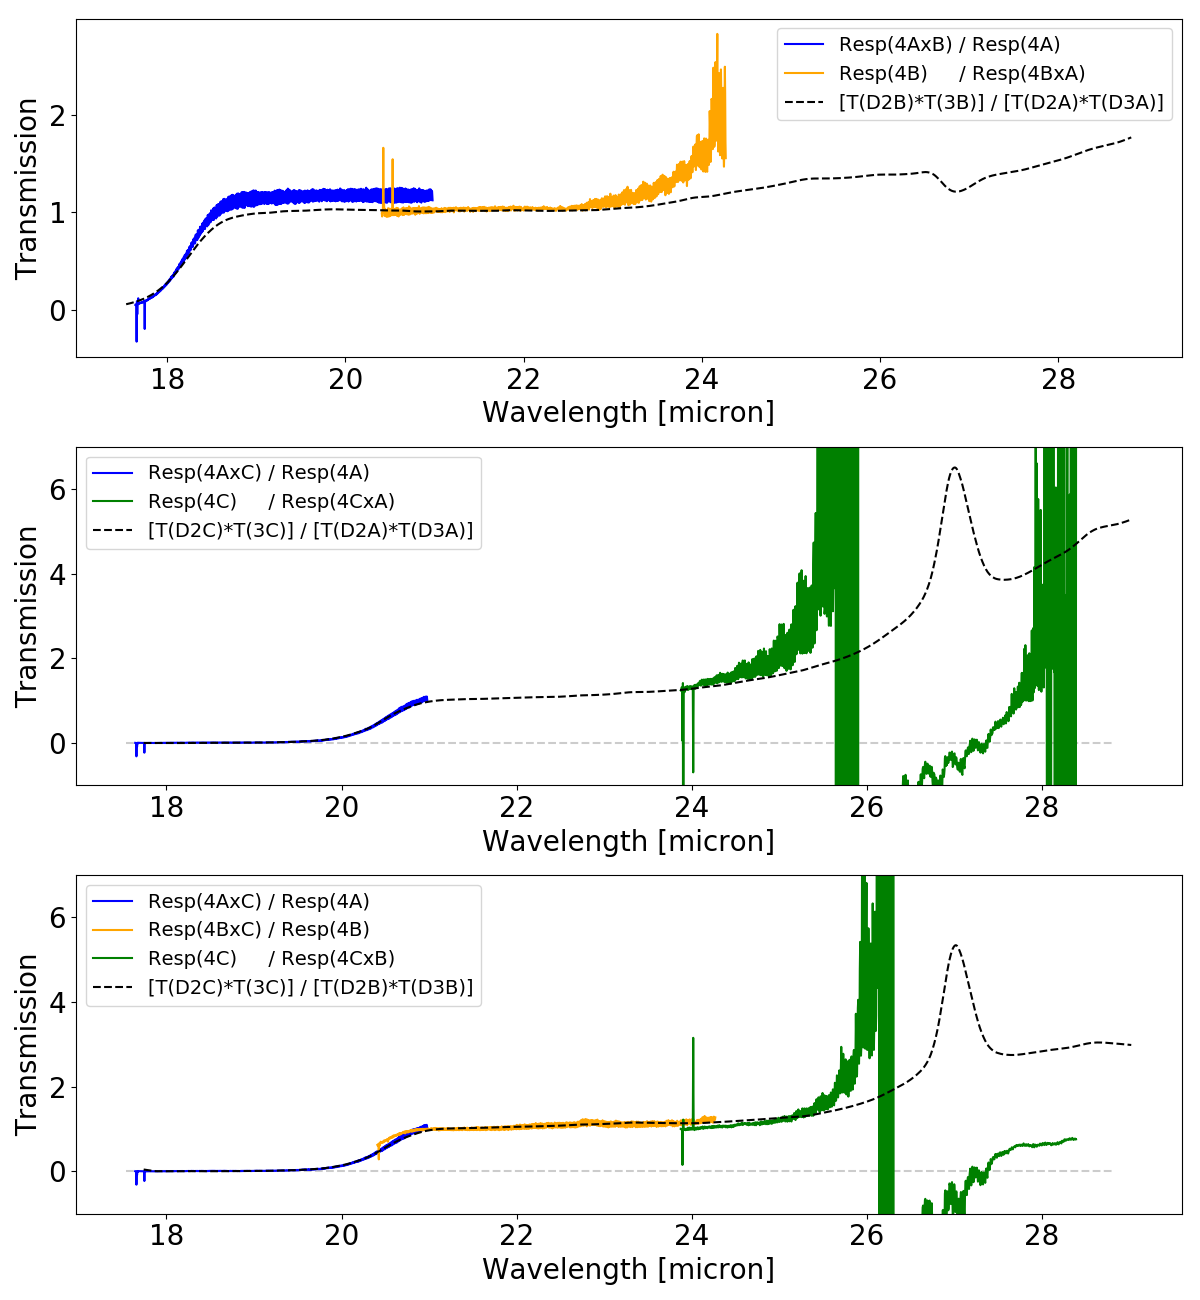

In [20]:
# channel 4 ==> FUDGE FACTORS!!!
fudge_factor_wavelength   = 0.2
fudge_factor_signal       = 0.03

sel = (filterWave>=maux.MRS_bands['4A'][0]) & (filterWave<=maux.MRS_bands['4C'][1])
fig,axs = plt.subplots(3,1,figsize=(12,13))
axs[0].plot(lambdaMap['4A'][:,47],(R_pixMap["4AxB"]/R_pixMap["4A"])[:,47],'b',label='Resp(4AxB) / Resp(4A)')
axs[0].plot(lambdaMap['4B'][:,47],(R_pixMap["4B"]/R_pixMap["4BxA"])[:,47],'orange',label='Resp(4B)     / Resp(4BxA)')
axs[0].plot(filterWave[sel],((D2B*D3B)/(D2A*D3A) )[sel],'k',linestyle='dashed',label='[T(D2B)*T(3B)] / [T(D2A)*T(D3A)]')

axs[1].plot(lambdaMap['4A'][:,47],(R_pixMap["4AxC"]/R_pixMap["4A"])[:,47]+fudge_factor_signal,'b',label='Resp(4AxC) / Resp(4A)')
axs[1].plot(lambdaMap['4C'][:,47],(R_pixMap["4C"]/R_pixMap["4CxA"])[:,47],'g',label='Resp(4C)     / Resp(4CxA)')
axs[1].plot(filterWave[sel]+fudge_factor_wavelength,((D2C*D3C)/(D2A*D3A) )[sel],'k',linestyle='dashed',label='[T(D2C)*T(3C)] / [T(D2A)*T(D3A)]')
axs[1].set_ylim(-1,7)
axs[1].hlines(0,maux.MRS_bands['4A'][0],maux.MRS_bands['4C'][1],'gray',alpha=0.4,linestyle='dashed')

axs[2].plot(lambdaMap['4A'][:,47],(R_pixMap["4AxC"]/R_pixMap["4A"])[:,47]+fudge_factor_signal,'b',label='Resp(4AxC) / Resp(4A)')
axs[2].plot(lambdaMap['4B'][:,47],(R_pixMap["4BxC"]/R_pixMap["4B"])[:,47],'orange',label='Resp(4BxC) / Resp(4B)')
axs[2].plot(lambdaMap['4C'][:,47],(R_pixMap["4C"]/R_pixMap["4CxB"])[:,47],'g',label='Resp(4C)     / Resp(4CxB)')
axs[2].plot(filterWave[sel]+fudge_factor_wavelength,((D2C*D3C)/(D2B*D3B) )[sel],'k',linestyle='dashed',label='[T(D2C)*T(3C)] / [T(D2B)*T(D3B)]')
axs[2].set_ylim(-1,7)
axs[2].hlines(0,maux.MRS_bands['4A'][0],maux.MRS_bands['4C'][1],'gray',alpha=0.4,linestyle='dashed')

for plot in range(3):
    axs[plot].legend()
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Transmission')
plt.tight_layout()

In [60]:
# Response cross-dichroic band 2AxB
band = '4AxB'

# interpolate the corresponding lab data transmission ratio applicable to specified band
sel = (D2B!=0) & (D3B!=0) & (D2A!=0) & (D3A!=0)
ip_transm = interp1d(filterWave[sel], ((D2B*D3B)/(D2A*D3A))[sel], kind='cubic')

# create pixel map of lab data transmission ratio
transm_pixMap[band] = np.full( validMap[band[:2]].shape, np.nan )

sel = (validMap[band[:2]]==1)
waves = np.reshape(lambdaMap[band[:2]][sel], -1)
transm_pixMap[band][sel] = ip_transm(waves)

# Derive MRS response based on the internal calibration source measurements and the lab data of the dichroic transmissions.
# For this cross-dichroic band, the int.cal.source response ratio is used to derive the MRS response of said band.
# The NaNs are not filled in because of the difference in the int.cal.source response ratio curve and the dichroic lab data transmission ratio curve.
# The ratio of the int.cal.source responses is smoothed using a Box2DKernel of 4 pixels size to reduce the high frequency noise in the final output.
response[band+'_lab'] = transm_pixMap[band] * photom[band[:2]]
smooth_R_ratio        = convolve((R_pixMap[band]/R_pixMap[band[:2]]),Box2DKernel(4))
response[band+'_data'] = smooth_R_ratio * photom[band[:2]]

# error propagation
response_err[band+'_lab']  = transm_pixMap[band] * photom_err[band[:2]]
R_pixMap_ratio_err         = stdev_propag(R_pixMap[band],R_pixMap[band[:2]],dR_pixMap[band],dR_pixMap[band[:2]])
response_err[band+'_data'] = stdev_propag((R_pixMap[band]/R_pixMap[band[:2]]),photom[band[:2]],R_pixMap_ratio_err,photom_err[band[:2]])

# save final output
response[band]     = response[band+'_data'].copy()
response_err[band] = response_err[band+'_lab'].copy()

In [19]:
# Response cross-dichroic band 3AxB
band = '4BxA'

# create pixel map of lab data transmission ratio
transm_pixMap[band] = np.full( validMap[band[:2]].shape, np.nan )

sel = (validMap[band[:2]]==1)
waves = np.reshape(lambdaMap[band[:2]][sel], -1)
transm_pixMap[band][sel] = ip_transm(waves)

# Derive MRS response based on the internal calibration source measurements and the lab data of the dichroic transmissions.
# For this cross-dichroic band, the dichroic transmission lab data ratiois used to derive the MRS response of said band.
# The reasons to use the lab data are:
# (1) the int.cal.source response ratio and the dichroic lab data ratio are in agreement at low wavelengths,
# (2) deviation between MRS data and lab data is caused by division by a small denominator in the case of the MRS data (should not "blow up" at long wavelengths though),
# (3) to minimize the noise in the derived response
response[band+'_lab'] = photom[band[:2]]/ transm_pixMap[band]

# error propagation
response_err[band+'_lab'] = photom_err[band[:2]] / transm_pixMap[band]

# save final output
response[band]     = response[band+'_lab'].copy()
response_err[band] = response_err[band+'_lab'].copy()

In [20]:
# Response cross-dichroic band 2AxB
band = '4AxC'

# INTRODUCING FUDGE FACTORS!!! Discrepancies in wavelength and negative signal yields unreasonable (unacceptable) results
fudge_factor_wavelength = 0.2

# interpolate the corresponding lab data transmission ratio applicable to specified band
sel = (D2C!=0) & (D3C!=0) & (D2A!=0) & (D3A!=0)
ip_transm = interp1d(filterWave[sel]+fudge_factor_wavelength, ((D2C*D3C)/(D2A*D3A))[sel], kind='cubic')

# create pixel map of lab data transmission ratio
transm_pixMap[band] = np.full( validMap[band[:2]].shape, np.nan )

sel = (validMap[band[:2]]==1)
waves = np.reshape(lambdaMap[band[:2]][sel], -1)
transm_pixMap[band][sel] = ip_transm(waves)

# Derive MRS response based on the internal calibration source measurements and the lab data of the dichroic transmissions.
# For this cross-dichroic band, the dichroic transmission lab data ratiois used to derive the MRS response of said band.
# The reasons to use the lab data are:
# (1) the int.cal.source response ratio and the dichroic lab data ratio are in agreement at low wavelengths,
# (2) deviation between MRS data and lab data is caused by division by a small denominator in the case of the MRS data (should not "blow up" at long wavelengths though),
# (3) to minimize the noise in the derived response
response[band+'_lab'] = transm_pixMap[band] * photom[band[:2]]

# error propagation
response_err[band+'_lab'] = transm_pixMap[band] * photom_err[band[:2]]

# save final output
response[band]     = response[band+'_lab'].copy()
response_err[band] = response_err[band+'_lab'].copy()

In [21]:
# Response cross-dichroic band 3AxB
band = '4CxA'

# interpolate the corresponding lab data transmission ratio applicable to specified band
sel = (D2C!=0) & (D3C!=0) & (D2A!=0) & (D3A!=0)
ip_transm = interp1d(filterWave[sel], ((D2C*D3C)/(D2A*D3A))[sel], kind='cubic')

# create pixel map of lab data transmission ratio
transm_pixMap[band] = np.full( validMap[band[:2]].shape, np.nan )

sel = (validMap[band[:2]]==1)
waves = np.reshape(lambdaMap[band[:2]][sel], -1)
transm_pixMap[band][sel] = ip_transm(waves)

# Derive MRS response based on the internal calibration source measurements and the lab data of the dichroic transmissions.
# For this cross-dichroic band, the dichroic transmission lab data ratiois used to derive the MRS response of said band.
# The reasons to use the lab data are:
# (1) the int.cal.source response ratio and the dichroic lab data ratio are in agreement at low wavelengths,
# (2) deviation between MRS data and lab data is caused by division by a small denominator in the case of the MRS data (should not "blow up" at long wavelengths though),
# (3) to minimize the noise in the derived response
response[band+'_lab'] = photom[band[:2]]/ transm_pixMap[band]

# error propagation
response_err[band+'_lab'] = photom_err[band[:2]] / transm_pixMap[band]

# save final output
response[band]     = response[band+'_lab'].copy()
response_err[band] = response_err[band+'_lab'].copy()

In [61]:
# Response cross-dichroic band 2AxB
band = '4BxC'

# interpolate the corresponding lab data transmission ratio applicable to specified band
sel = (D2C!=0) & (D3C!=0) & (D2B!=0) & (D3B!=0)
ip_transm = interp1d(filterWave[sel], ((D2C*D3C)/(D2B*D3B))[sel], kind='cubic')

# create pixel map of lab data transmission ratio
transm_pixMap[band] = np.full( validMap[band[:2]].shape, np.nan )

sel = (validMap[band[:2]]==1)
waves = np.reshape(lambdaMap[band[:2]][sel], -1)
transm_pixMap[band][sel] = ip_transm(waves)

# Derive MRS response based on the internal calibration source measurements and the lab data of the dichroic transmissions.
# For this cross-dichroic band, the int.cal.source response ratio is used to derive the MRS response of said band.
# To fill in the abundant NaNs in the int.cal.source response ratio pixel map, we use the response derived from using the lab data (other ideas are welcome).
response[band+'_lab'] = transm_pixMap[band] * photom[band[:2]]
response[band+'_data'] = (R_pixMap[band[:2]]/R_pixMap[band]) * photom[band[:2]]
response[band+'_data'][np.isnan(response[band+'_data'])] = response[band+'_lab'][np.isnan(response[band+'_data'])]

# error propagation
response_err[band+'_lab']  = transm_pixMap[band] * photom_err[band[:2]]
R_pixMap_ratio_err         = stdev_propag(R_pixMap[band[:2]],R_pixMap[band],dR_pixMap[band[:2]],dR_pixMap[band])
response_err[band+'_data'] = stdev_propag((R_pixMap[band[:2]]/R_pixMap[band]),photom[band[:2]],R_pixMap_ratio_err,photom_err[band[:2]])
response_err[band+'_data'][np.isnan(response[band+'_data'])] = response_err[band+'_lab'][np.isnan(response[band+'_data'])]

# save final output
response[band]     = response[band+'_data'].copy()
response_err[band] = response_err[band+'_lab'].copy()

In [23]:
# Response cross-dichroic band 3AxB
band = '4CxB'

# create pixel map of lab data transmission ratio
transm_pixMap[band] = np.full( validMap[band[:2]].shape, np.nan )

sel = (validMap[band[:2]]==1)
waves = np.reshape(lambdaMap[band[:2]][sel], -1)
transm_pixMap[band][sel] = ip_transm(waves)

# Derive MRS response based on the internal calibration source measurements and the lab data of the dichroic transmissions.
# For this cross-dichroic band, the dichroic transmission lab data ratiois used to derive the MRS response of said band.
# The reasons to use the lab data are:
# (1) deviation between MRS data and lab data is caused by division by a small denominator in the case of the MRS data (should not "blow up" at long wavelengths though),
# (2) to minimize the noise in the derived response
# Note that in this band the int.cal.source response ratio and the dichroic lab data ratio deviate, and thus it is expected that the derived response is not ideally representative of the real response (but that's the best we can do right now)
response[band+'_lab'] = photom[band[:2]]/ transm_pixMap[band]

# error propagation
response_err[band+'_lab'] = photom_err[band[:2]] / transm_pixMap[band]

# save final output
response[band]     = response[band+'_lab'].copy()
response_err[band] = response_err[band+'_lab'].copy()

In [62]:
for key in response.keys():
    if len(key)>4: del response[key]

In [63]:
# save response output
funcs.save_obj(response,'cross_dichroic_response')
funcs.save_obj(response_err,'cross_dichroic_response_error')

Let's plot the derived MRS spectrophotometric response to an external extended source observation in cross-dichroic configuration. We also plot 1d spectra of the same responses and their corresponding uncertainties.

<IPython.core.display.Javascript object>


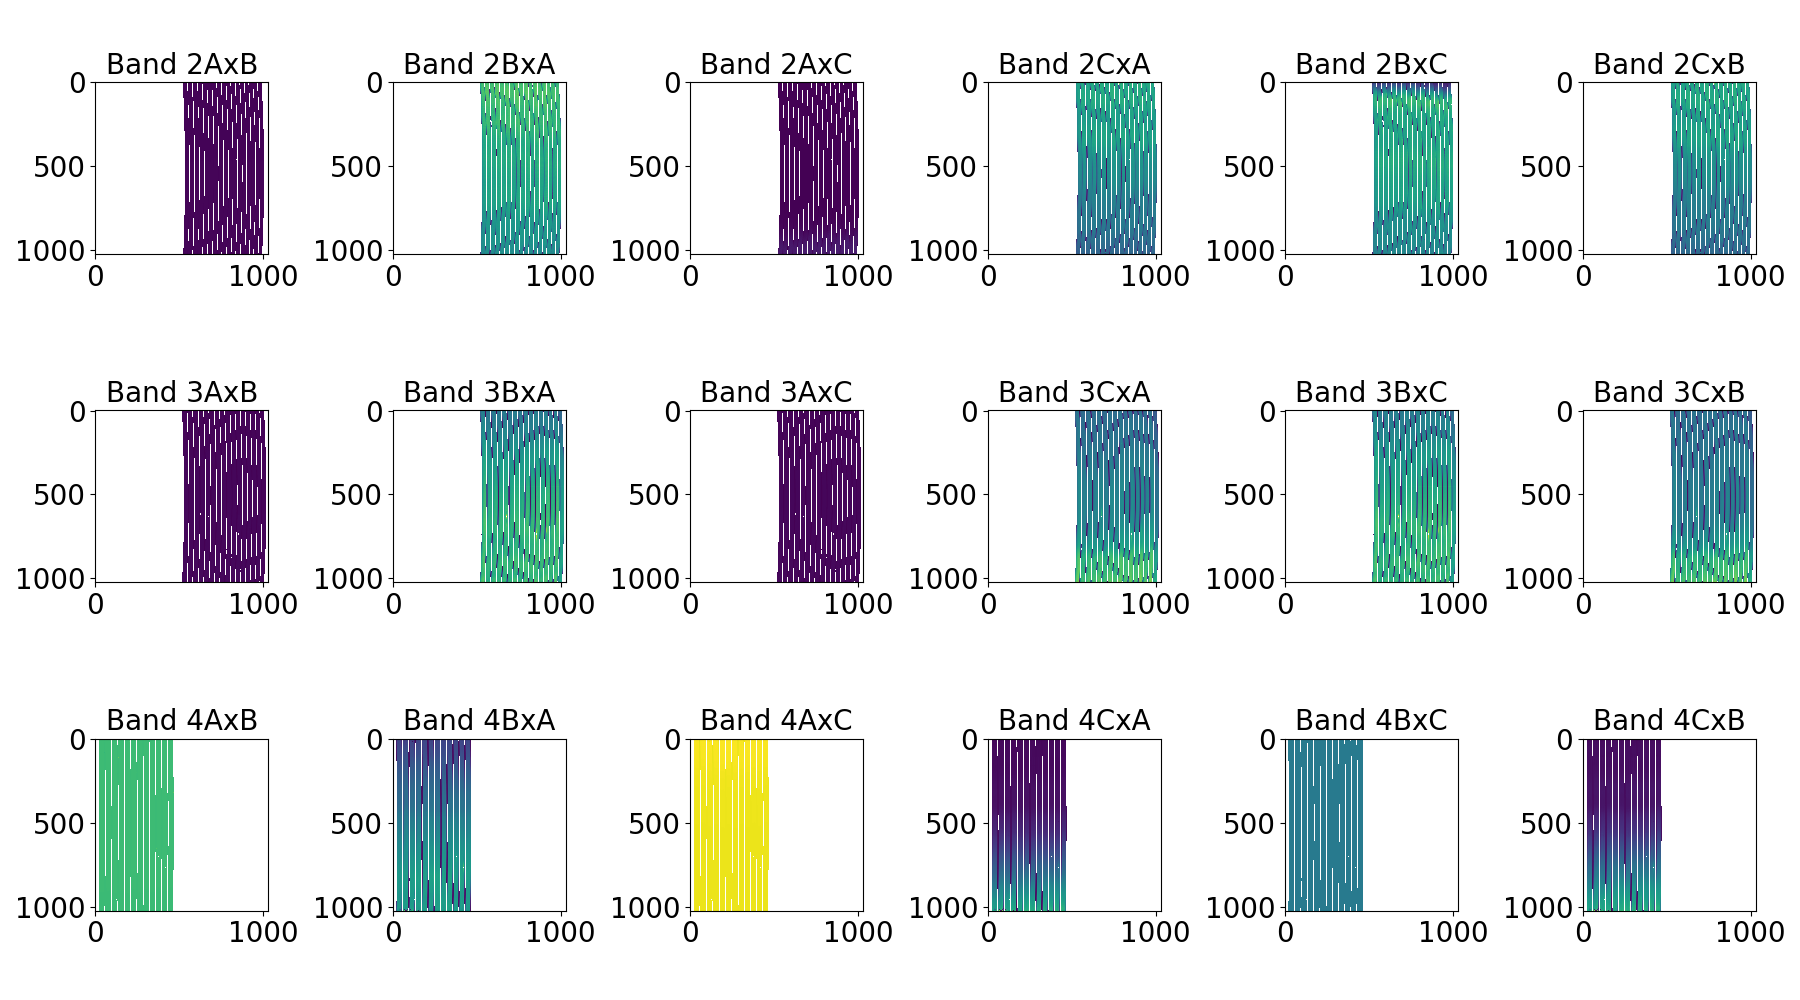

In [30]:
fig,axs = plt.subplots(3,6,figsize=(18,10))
axs[0,0].imshow(response['2AxB'])
axs[0,0].set_title('Band 2AxB')
axs[0,1].imshow(response['2BxA'])
axs[0,1].set_title('Band 2BxA')
axs[0,2].imshow(response['2AxC'])
axs[0,2].set_title('Band 2AxC')
axs[0,3].imshow(response['2CxA'])
axs[0,3].set_title('Band 2CxA')
axs[0,4].imshow(response['2BxC'])
axs[0,4].set_title('Band 2BxC')
axs[0,5].imshow(response['2CxB'])
axs[0,5].set_title('Band 2CxB')
axs[1,0].imshow(response['3AxB'])
axs[1,0].set_title('Band 3AxB')
axs[1,1].imshow(response['3BxA'])
axs[1,1].set_title('Band 3BxA')
axs[1,2].imshow(response['3AxC'])
axs[1,2].set_title('Band 3AxC')
axs[1,3].imshow(response['3CxA'])
axs[1,3].set_title('Band 3CxA')
axs[1,4].imshow(response['3BxC'])
axs[1,4].set_title('Band 3BxC')
axs[1,5].imshow(response['3CxB'])
axs[1,5].set_title('Band 3CxB')
axs[2,0].imshow(response['4AxB'])
axs[2,0].set_title('Band 4AxB')
axs[2,1].imshow(response['4BxA'])
axs[2,1].set_title('Band 4BxA')
axs[2,2].imshow(response['4AxC'])
axs[2,2].set_title('Band 4AxC')
axs[2,3].imshow(response['4CxA'])
axs[2,3].set_title('Band 4CxA')
axs[2,4].imshow(response['4BxC'])
axs[2,4].set_title('Band 4BxC')
axs[2,5].imshow(response['4CxB'])
axs[2,5].set_title('Band 4CxB')
plt.tight_layout()

<IPython.core.display.Javascript object>


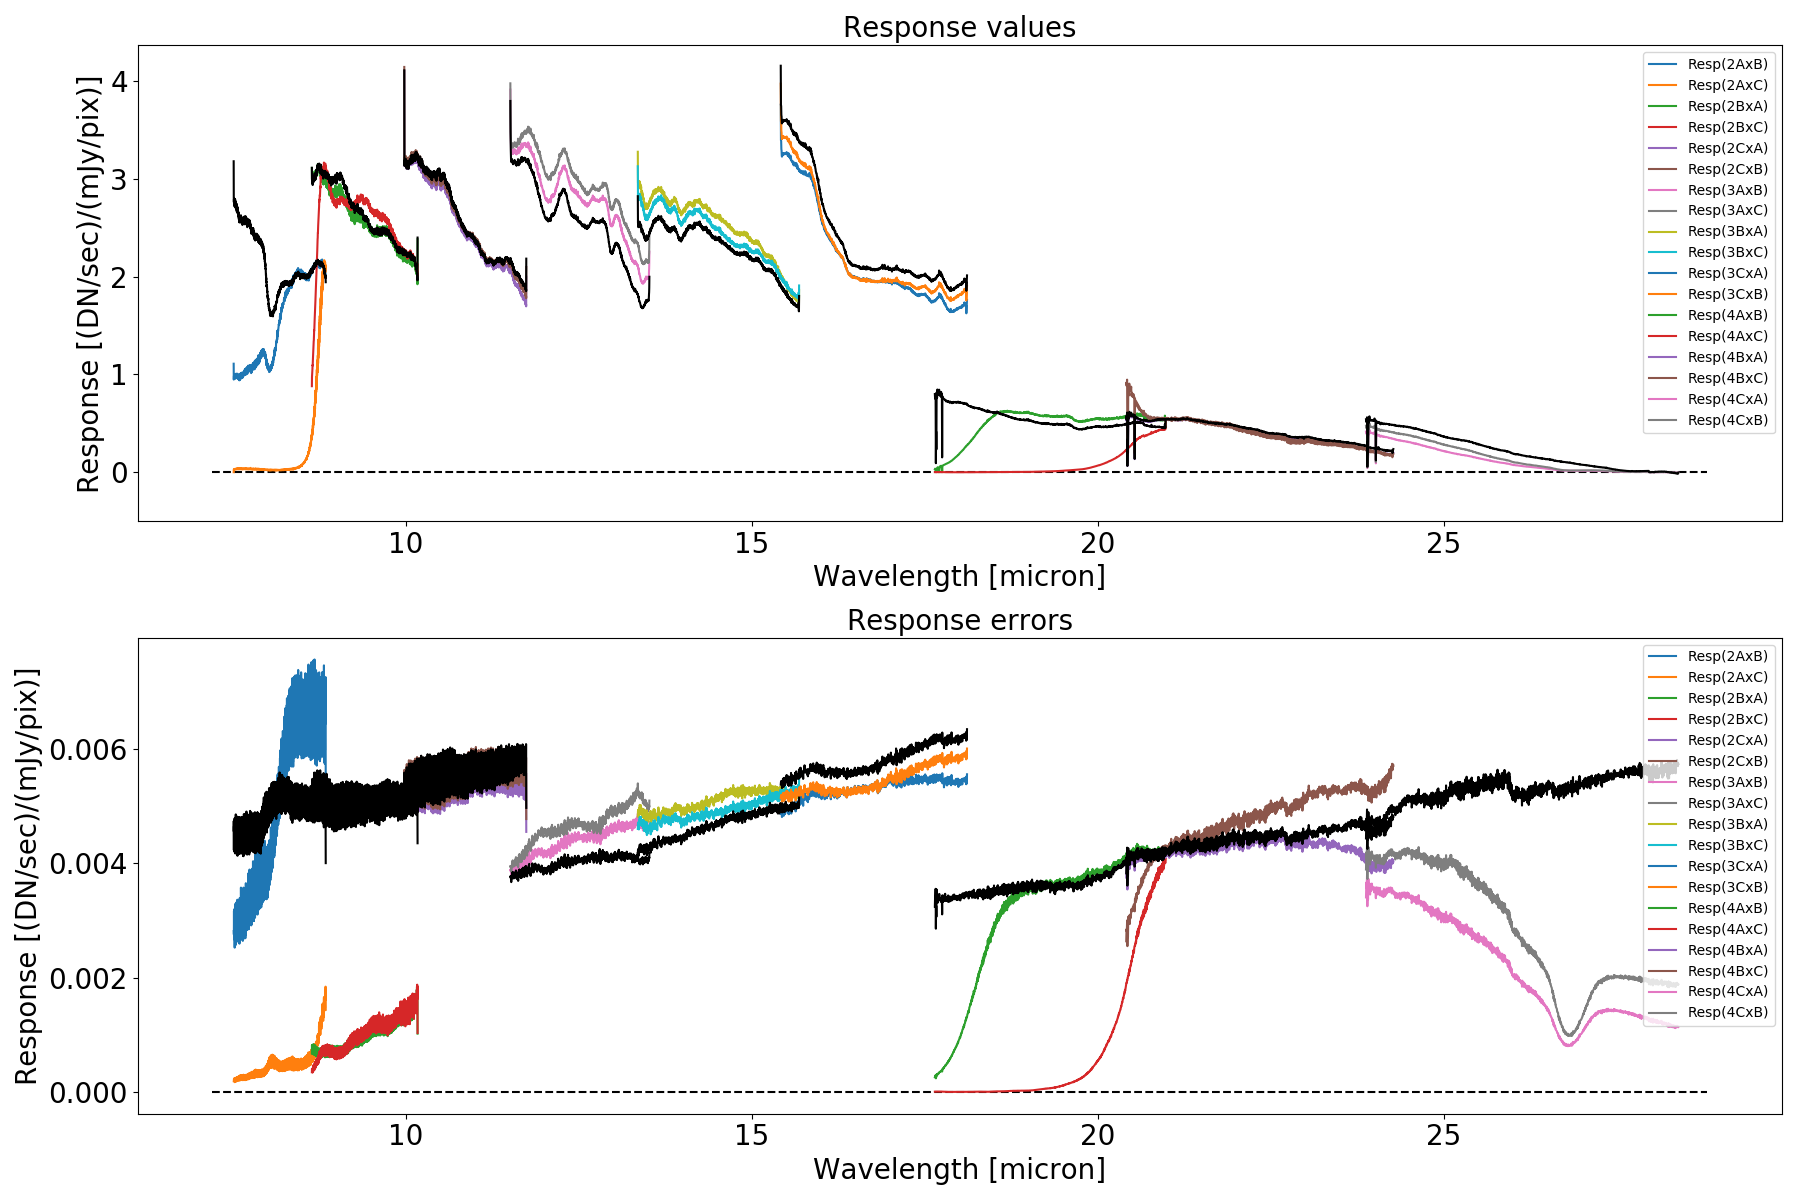

In [68]:
fig,axs = plt.subplots(2,1,figsize=(18,12))
axs[0].set_title('Response values')
axs[1].set_title('Response errors')
for band in cross_bands:
    if band[0] in ['2','3']:
        axs[0].plot(lambdaMap[band[:2]][:,537],(response[band])[:,537],label='Resp({})'.format(band))
        axs[1].plot(lambdaMap[band[:2]][:,537],(response_err[band])[:,537],label='Resp({})'.format(band))
    if band[0] == '4':
        axs[0].plot(lambdaMap[band[:2]][:,47],(response[band])[:,47],label='Resp({})'.format(band))
        axs[1].plot(lambdaMap[band[:2]][:,47],(response_err[band])[:,47],label='Resp({})'.format(band))
for band in bands:
    if len(band) == 4:
        continue
    if band[0] in ['2','3']:
        axs[0].plot(lambdaMap[band][:,537],(photom[band])[:,537],'k')
        axs[1].plot(lambdaMap[band][:,537],(photom_err[band])[:,537],'k')
    if band[0] == '4':
        axs[0].plot(lambdaMap[band][:,47],(photom[band])[:,47],'k')
        axs[1].plot(lambdaMap[band][:,47],(photom_err[band])[:,47],'k')
axs[0].set_ylim(-0.5)
for plot in range(2):
    axs[plot].hlines(0,7.2,28.8,linestyle='dashed')
    axs[plot].legend(fontsize=10,)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Response [(DN/sec)/(mJy/pix)]')
plt.tight_layout()